- This notebook contains functions for noise removal, and cell volume calculation

In [1]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')


import glob
import matplotlib.pyplot as plt
#import tensorflow as tf
import numpy as np
import cv2 as cv
import json


In [2]:
image = cv.imread("data/test/Im037_0.jpg")

#normalize rgb image
image_normalized = ((image > 127) * 255.0).astype(np.uint8)


#convert image to gray scale
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

#binarize image
image_gray_normalized = ((image_gray > 127) * 255.0).astype(np.uint8)


mask = cv.imread("data/test/mask/Im037_0.jpg")

#convert image to gray scale
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

#binarize image
mask = ((mask > 127) * 255.0).astype(np.uint8)



edge = cv.imread("data/test/edge/Im037_0.jpg")

#convert image to gray scale
edge = cv.cvtColor(edge, cv.COLOR_BGR2GRAY)

#binarize image
edge = ((edge > 127) * 255.0).astype(np.uint8)


mask_edge = (((mask - edge) > 0) * 255.0).astype(np.uint8)



- Apply Connected Component Labeling

cells number is: 718


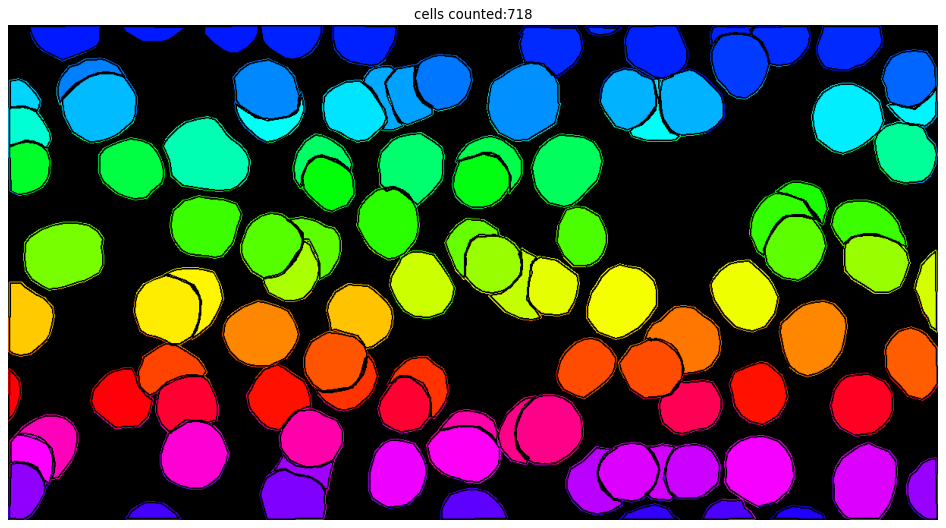

In [21]:
ret, labels = cv.connectedComponents(mask_edge)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0


print('cells number is:', ret-1)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title('cells counted:'+ str(ret-1))
ax.imshow(labeled_img)

- here we try to extract each cell individually

In [4]:
#this function takes a gray scale image and filters non connected objects by size
def surfaceFilter(image, min_size = None, max_size = None, colorize = False, gray = False):
    img = image.copy()
    
    ret, labels = cv.connectedComponents(img)
    
    label_codes = np.unique(labels)
    
    result_image = labels + 1
    
    for label in label_codes:
        count = (labels == label).sum()
        if min_size is not None and (count < min_size):
            result_image[labels == label] = 0
        if max_size is not None and (count > max_size):
            result_image[labels == label] = 0
            
    if colorize:
        result_image = colorize_unique(result_image)
        
        if gray:
            result_image = cv.cvtColor(result_image, cv.COLOR_BGR2GRAY)
    
    return result_image

def colorize_unique(image):
    label_hue = np.uint8(179 * image / np.max(image))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    return labeled_img

def showImg(img, title="image", figSize=(15, 20), dpi=80):
    fig = plt.figure(figsize=figSize, dpi=dpi)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.set_title(title)
    ax.imshow(img)

def get_label(word):
    words_to_numerical_labels_dict = {
        'None': 0,
        'Truck': 1,
        'Tanker': 2,
        'Trailer': 3
    }
    return words_to_numerical_labels_dict[word]


def make_polygon_lists(markup_files):
    marked_dicts = []
    for file_name in markup_files:
        if os.path.isfile(file_name):
            with open(file_name, 'r') as markup_file:
                marked_dicts += [json.load(markup_file)]

    polygon_lists_list = []
    for marked_dict in marked_dicts:
        polygon_list = []

        for poly in marked_dict['markup']:
            vertex_list = []

            for vertex in poly['vertices']:
                vertex_list += [(vertex['x'], vertex['y'])]
            polygon_list += [(vertex_list, get_label(poly['object_label']))]

        polygon_lists_list += [polygon_list]

    return polygon_lists_list


In [45]:
image_sample = mask_edge.copy()

print(f"count before denoise = {ret}")

image_sample = surfaceFilter(image_sample, min_size = 500, max_size= None, colorize = False)

showImg(image_sample)

print(f"count after denoise = {len(np.unique(image_sample))}")

polygon_list = make_polygon_lists(["data/test/Im037_0.json"])[0]
len(polygon_list)

NameError: name 'ret' is not defined

- apply Countours Algorithm

In [46]:
import imutils

- Find contours with cv.findContours

[INFO] 104 unique contours found


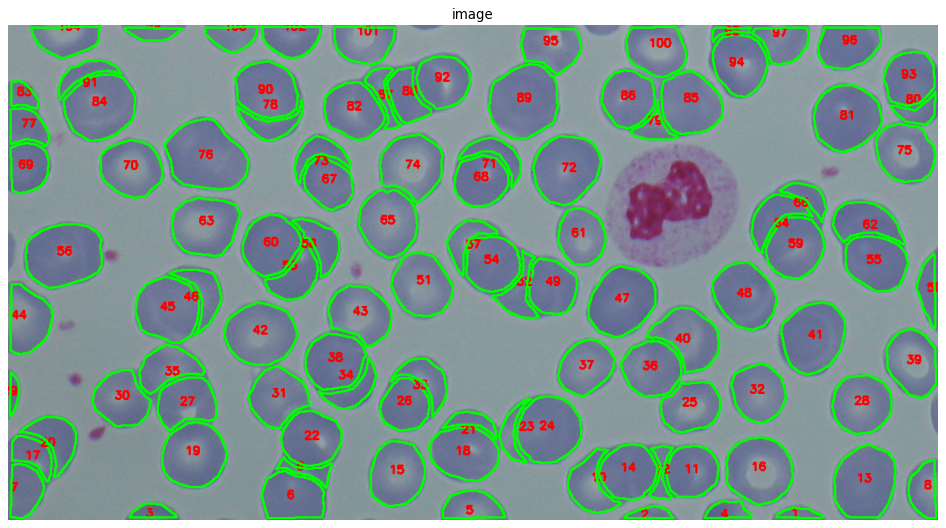

In [28]:
image_sample1 = surfaceFilter(mask_edge, min_size = 400, max_size= None, colorize = True, gray=True)

image_sample2 = image.copy()

contours = cv.findContours(image_sample1.copy(), cv.RETR_EXTERNAL,
	cv.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)
print("[INFO] {} unique contours found".format(len(contours)))

# loop over the contours
for (i, c) in enumerate(contours):
	# draw the contour
	((x, y), _) = cv.minEnclosingCircle(c)
	cv.putText(image_sample2, "{}".format(i + 1), (int(x) - 10, int(y)),
		cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
	cv.drawContours(image_sample2, [c], -1, (0, 255, 0), 2)
# show the output image
showImg(image_sample2)

- Apply Watershed Alogithm

In [7]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils

/tmp/ipykernel_101564/2352489834.py:13: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20,


[INFO] 106 unique segments found


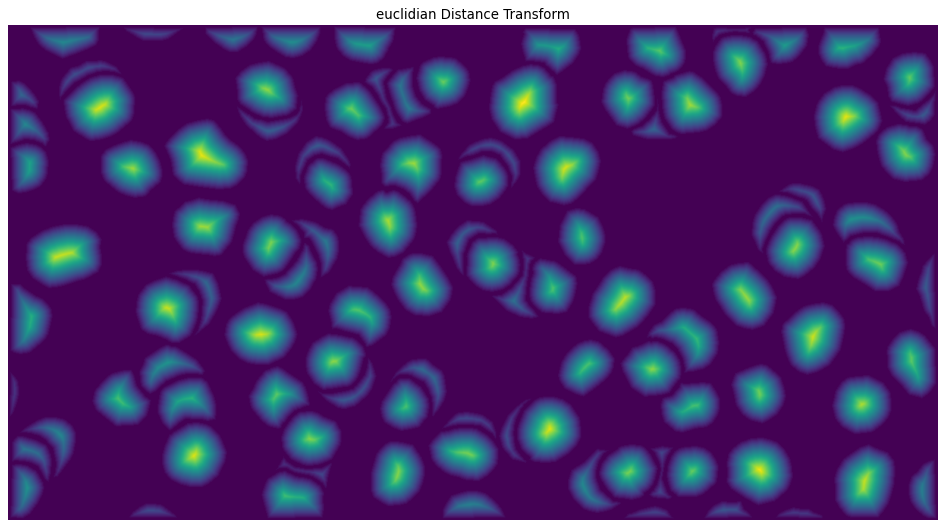

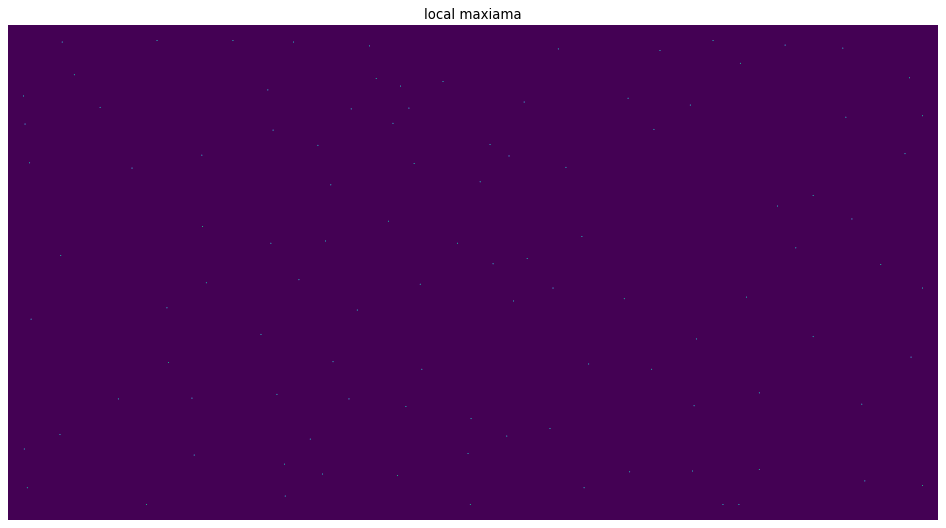

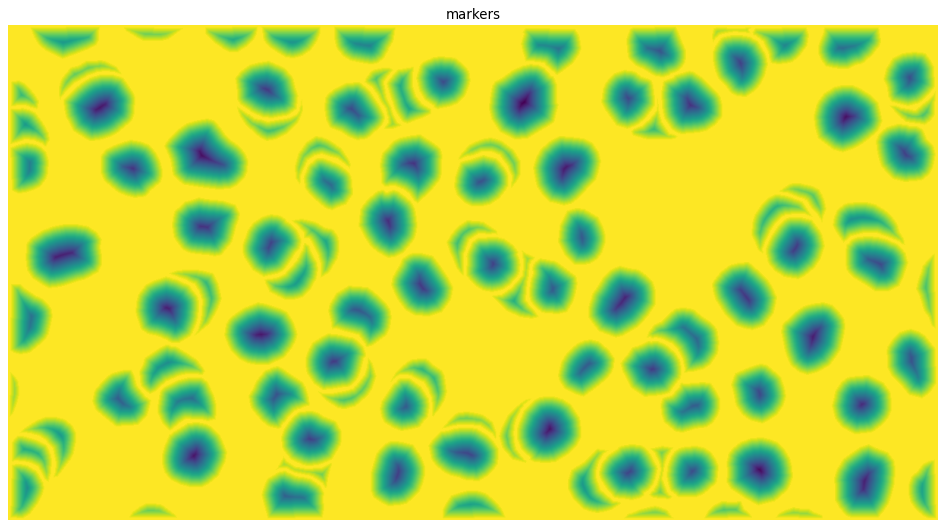

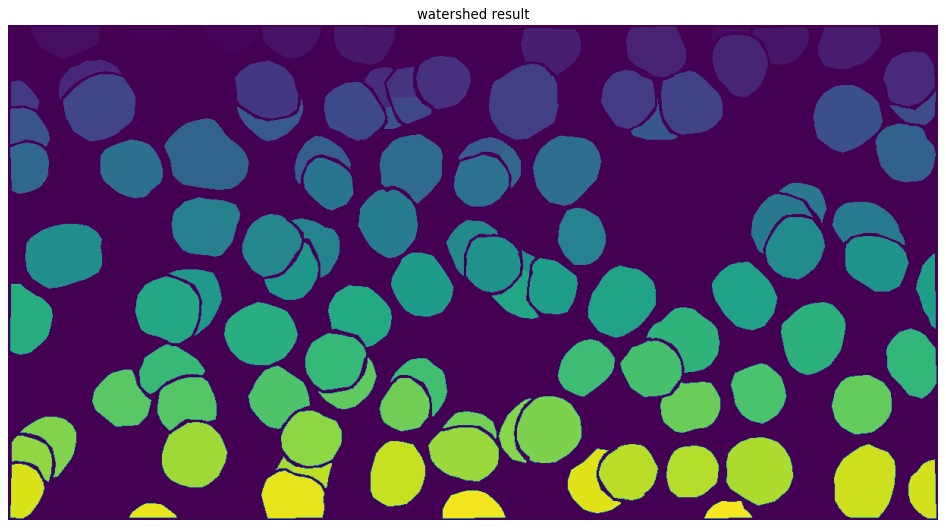

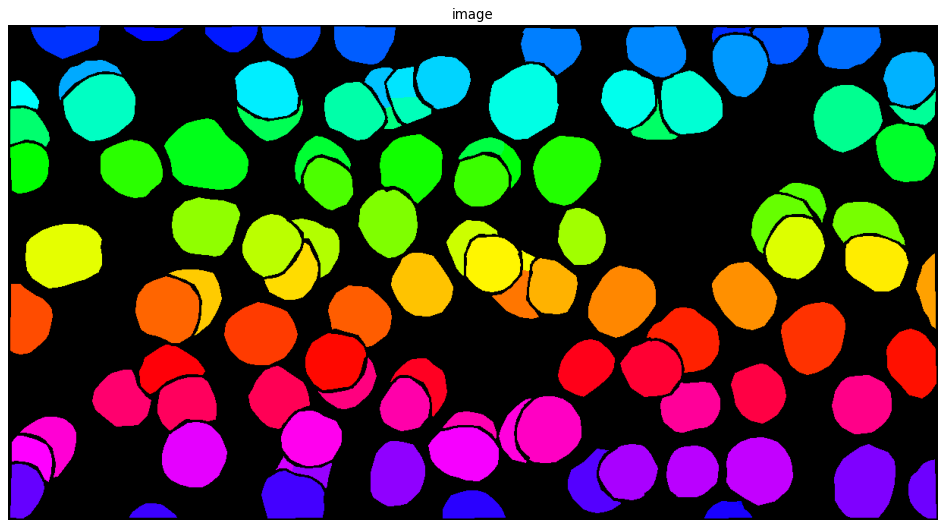

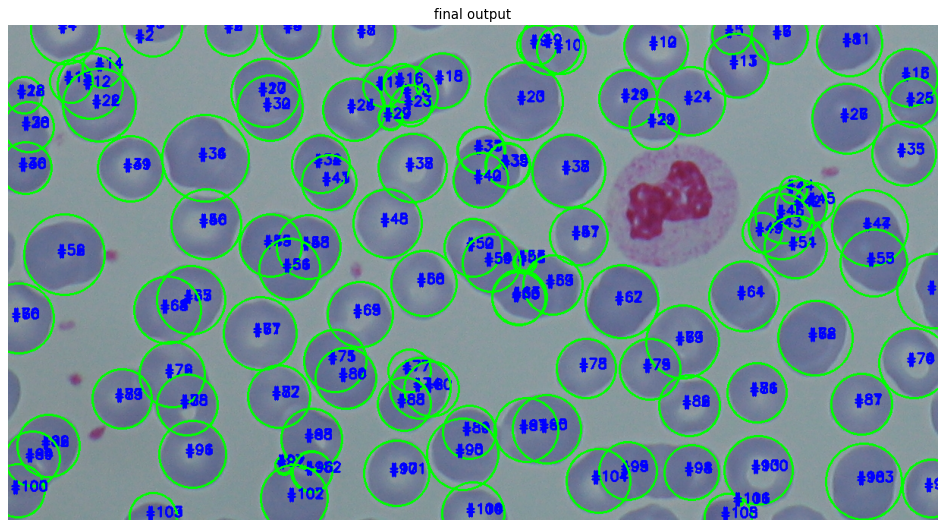

In [20]:
image_sample3 = surfaceFilter(mask_edge, min_size = 400, max_size= None, colorize = True, gray=True)

D = ndimage.distance_transform_edt(image_sample3)

showImg(D, title="euclidian Distance Transform")

#DT = ndimage.morphology.distance_transform_cdt(image_sample3, metric="taxicab")

#showImg(DT, title="euclidian Distance Transform")



localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=image_sample3)


showImg(localMax, "local maxiama")

# perform a connected component analysis on the local peaks to label each local maxima with a num,
# using 8-connectivity, then appy the Watershed algorithm we can also use connected component labeling
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]

#same image as local maxima
showImg(-D, title="markers")

labels = watershed(-D, markers, mask=image_sample3)

print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

showImg(labels, title="watershed result")

showImg(colorize_unique(labels))

#loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(image_sample3.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
		cv.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv.minEnclosingCircle(c)
	cv.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
showImg(image, title="final output")